## Fit distributions on Tests Data

In [1]:
## Import libraries
import os
import gzip
import json
import datetime
import itertools
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from intersect import intersection

import warnings

warnings.filterwarnings("ignore")
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

## Import dataframe

In [2]:
passing_train = pd.read_csv('../data/processed/passing_train.csv')
failing_train = pd.read_csv('../data/processed/failing_train.csv')

In [3]:
passing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,12,2022-12-14T15:46:53Z,2022-12-14T15:47:14Z,3696409364,completed,success,21.0,28698040
1,19,2022-10-18T22:05:12Z,2022-10-18T22:05:39Z,3277249376,completed,success,27.0,28698040
2,25,2022-10-13T17:49:42Z,2022-10-13T17:50:28Z,3244532523,completed,success,46.0,28698040
3,5,2022-07-12T21:11:13Z,2022-07-12T21:11:42Z,2659424327,completed,success,29.0,28698040
4,22,2022-07-05T15:28:26Z,2022-07-05T15:29:06Z,2617219129,completed,success,40.0,28698040


In [4]:
failing_train.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,20,2022-10-10T15:46:57Z,2022-10-10T15:47:54Z,3220628244,completed,failure,57.0,28698040
1,9,2022-09-01T22:31:42Z,2022-09-01T22:32:36Z,2975376600,completed,failure,54.0,28698040
2,29,2023-01-12T18:04:21Z,2023-01-12T18:04:59Z,3904825511,completed,failure,38.0,28698040
3,29,2022-12-01T18:58:49Z,2022-12-01T18:59:25Z,3595655421,completed,failure,36.0,28698040
4,27,2022-10-07T17:50:17Z,2022-10-07T17:51:07Z,3206656422,completed,failure,50.0,28698040


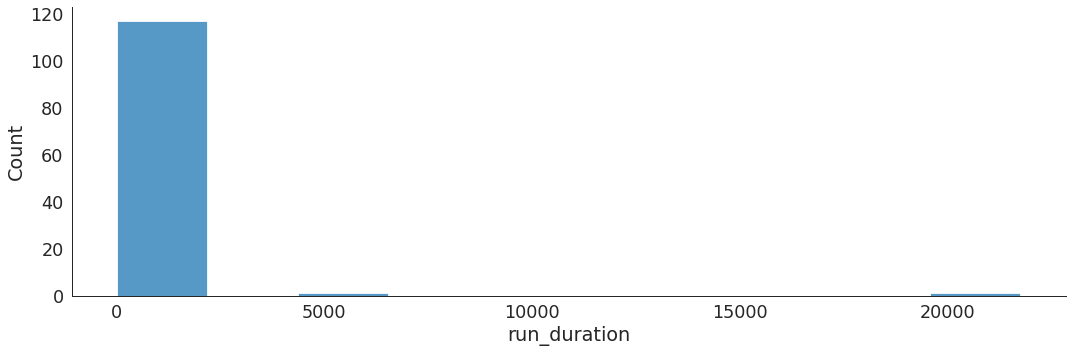

In [5]:
# Distribution of values of run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=failing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

In [6]:
# Since the data here is heavily skewed, hence implementing 
# log transformation here.
failing_train.run_duration = np.log(failing_train.run_duration)

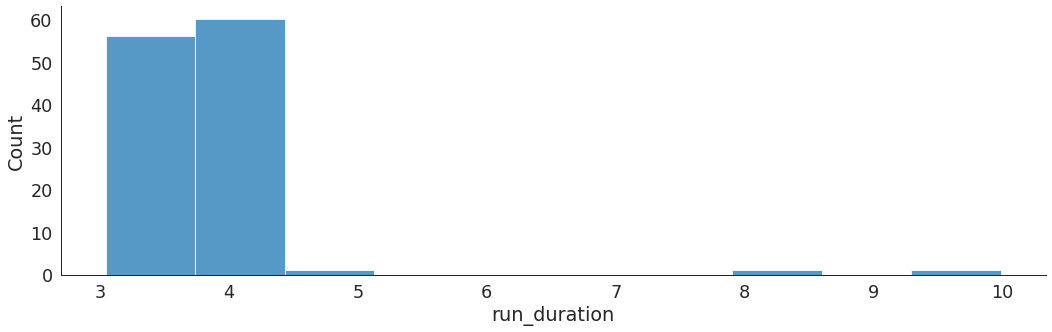

In [7]:
# Distribution of values of failing run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=failing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

In [8]:
# create a separate set of values for failing durations
fail_run_duration = failing_train.run_duration.values

Fitting 110 distributions: 100%|██████████| 110/110 [00:57<00:00,  1.92it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
tukeylambda,0.002575,inf,-1263.838645,0.026234,0.178301,0.000882
levy_stable,0.005742,487.864155,-1163.637688,inf,0.123998,0.047126
semicircular,0.009851,inf,-1108.959689,0.026010,0.107664,0.117684
rdist,0.010874,inf,-1092.423379,0.026388,0.201873,0.000100
logistic,0.013565,201.700105,-1070.885686,inf,0.111320,0.096973


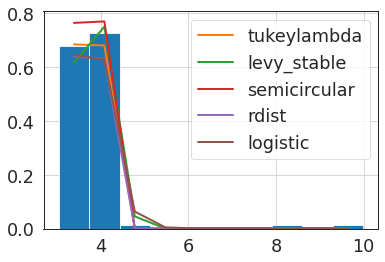

In [9]:
f = Fitter(fail_run_duration,
           distributions=get_distributions(), bins =10)
f.fit()
f.summary()

In [10]:
# Find best failing distribution
best_failing_dist = f.get_best(method="sumsquare_error")
best_failing_dist

{'tukeylambda': {'lam': 1.3621483701266333,
  'loc': 3.7552152783749952,
  'scale': 0.9680690945551738}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
tukeylambda,0.002575,inf,-1263.838645,0.026234,0.178301,0.000882


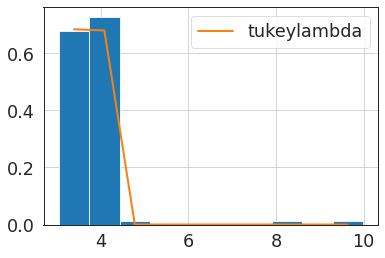

In [11]:
f = Fitter(fail_run_duration,
           distributions=best_failing_dist, bins =10)
f.fit()
f.summary()

In [12]:
f_dist = list(best_failing_dist.keys())[0]

In [13]:
# Calculate the parameters for the failing distribution curve
f_params = f.fitted_param[f_dist]
f_params

(1.3621483701266333, 3.7552152783749952, 0.9680690945551738)

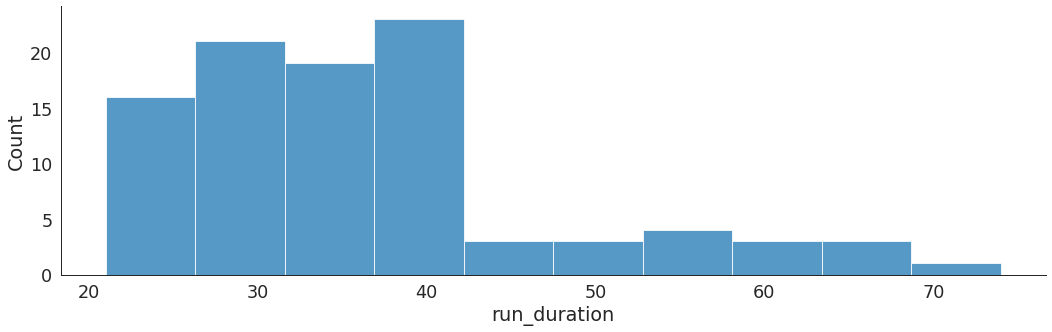

In [14]:
# Distribution of values of passing run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=passing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

In [15]:
# Since the failing data here is heavily skewed, hence implementing 
# log transformation here as well so we can get an OSP after reversing the log.
passing_train.run_duration = np.log(passing_train.run_duration)

In [16]:
# create a separate set of values for the passing run times.
pass_run_duration = passing_train.run_duration.values
pass_run_duration

array([3.04452244, 3.29583687, 3.8286414 , 3.36729583, 3.68887945,
       3.87120101, 3.63758616, 3.55534806, 3.36729583, 3.40119738,
       3.33220451, 3.13549422, 3.33220451, 3.98898405, 3.52636052,
       3.52636052, 3.71357207, 3.76120012, 3.36729583, 3.4339872 ,
       3.97029191, 3.49650756, 3.33220451, 3.40119738, 3.66356165,
       3.09104245, 3.58351894, 3.33220451, 4.20469262, 3.71357207,
       3.73766962, 3.4339872 , 3.17805383, 3.36729583, 3.61091791,
       3.09104245, 3.17805383, 3.63758616, 4.15888308, 4.00733319,
       3.33220451, 3.13549422, 3.33220451, 3.73766962, 3.52636052,
       4.30406509, 3.8918203 , 3.61091791, 3.93182563, 3.71357207,
       3.36729583, 3.04452244, 3.09104245, 3.4657359 , 3.73766962,
       3.04452244, 3.49650756, 3.66356165, 3.63758616, 4.20469262,
       3.29583687, 3.52636052, 3.04452244, 3.52636052, 3.66356165,
       3.66356165, 3.68887945, 4.11087386, 3.49650756, 3.52636052,
       3.40119738, 3.76120012, 4.07753744, 3.52636052, 3.58351

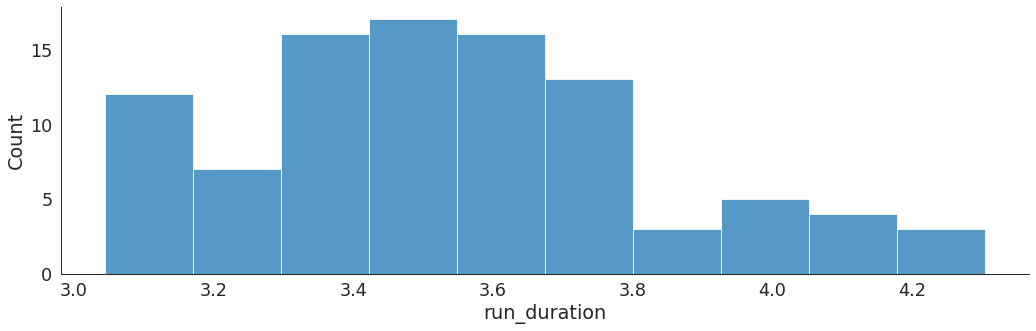

In [17]:
# Distribution of values of passing run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=passing_train, x="run_duration", kind="hist", bins = 10, aspect = 3)

Fitting 110 distributions:  75%|███████▌  | 83/110 [00:38<00:13,  2.03it/s]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 110 distributions: 100%|██████████| 110/110 [01:29<00:00,  1.23it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
foldnorm,0.500504,15.111935,-490.929814,0.064776,0.077972,0.576518
exponnorm,0.569766,17.015816,-478.487234,0.070384,0.060161,0.857048
fisk,0.577094,17.369869,-477.260345,0.068131,0.063796,0.805667
mielke,0.578158,19.116049,-472.519233,0.069309,0.060921,0.846801
burr12,0.579326,19.585794,-472.325424,0.070056,0.058647,0.876572


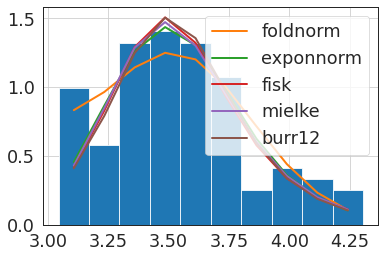

In [18]:
p = Fitter(pass_run_duration,
           distributions=get_distributions(), bins =10)
p.fit()
p.summary()

In [19]:
# find the best passing distribution
best_passing_dist = p.get_best(method="sumsquare_error")
best_passing_dist

{'foldnorm': {'c': 1.492410107517821,
  'loc': 3.0445223893523847,
  'scale': 0.32217035116013676}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
foldnorm,0.500504,15.111935,-490.929814,0.064776,0.077972,0.576518


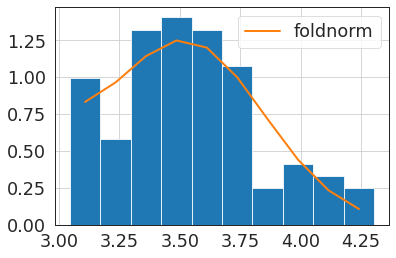

In [20]:
p = Fitter(pass_run_duration,
           distributions=best_passing_dist, bins =10)
p.fit()
p.summary()

In [21]:
p_dist = list(best_passing_dist.keys())[0]

In [22]:
# Calculate the parameters for the passing distribution curve
p_params = p.fitted_param[p_dist]
p_params

(1.492410107517821, 3.0445223893523847, 0.32217035116013676)

## Caluculate the OSP 

In [23]:
x_passing = np.linspace(pass_run_duration.min(), pass_run_duration.max(), num = len(pass_run_duration))
x_passing

array([3.04452244, 3.05778078, 3.07103913, 3.08429747, 3.09755581,
       3.11081416, 3.1240725 , 3.13733084, 3.15058919, 3.16384753,
       3.17710588, 3.19036422, 3.20362256, 3.21688091, 3.23013925,
       3.24339759, 3.25665594, 3.26991428, 3.28317263, 3.29643097,
       3.30968931, 3.32294766, 3.336206  , 3.34946434, 3.36272269,
       3.37598103, 3.38923938, 3.40249772, 3.41575606, 3.42901441,
       3.44227275, 3.45553109, 3.46878944, 3.48204778, 3.49530612,
       3.50856447, 3.52182281, 3.53508116, 3.5483395 , 3.56159784,
       3.57485619, 3.58811453, 3.60137287, 3.61463122, 3.62788956,
       3.64114791, 3.65440625, 3.66766459, 3.68092294, 3.69418128,
       3.70743962, 3.72069797, 3.73395631, 3.74721466, 3.760473  ,
       3.77373134, 3.78698969, 3.80024803, 3.81350637, 3.82676472,
       3.84002306, 3.85328141, 3.86653975, 3.87979809, 3.89305644,
       3.90631478, 3.91957312, 3.93283147, 3.94608981, 3.95934816,
       3.9726065 , 3.98586484, 3.99912319, 4.01238153, 4.02563

In [24]:
x_failing = np.linspace(fail_run_duration.mean(), fail_run_duration.max(), num = len(fail_run_duration))
x_failing

array([3.80510775, 3.85750018, 3.90989262, 3.96228505, 4.01467749,
       4.06706992, 4.11946236, 4.17185479, 4.22424722, 4.27663966,
       4.32903209, 4.38142453, 4.43381696, 4.4862094 , 4.53860183,
       4.59099427, 4.6433867 , 4.69577913, 4.74817157, 4.800564  ,
       4.85295644, 4.90534887, 4.95774131, 5.01013374, 5.06252618,
       5.11491861, 5.16731104, 5.21970348, 5.27209591, 5.32448835,
       5.37688078, 5.42927322, 5.48166565, 5.53405809, 5.58645052,
       5.63884295, 5.69123539, 5.74362782, 5.79602026, 5.84841269,
       5.90080513, 5.95319756, 6.00559   , 6.05798243, 6.11037486,
       6.1627673 , 6.21515973, 6.26755217, 6.3199446 , 6.37233704,
       6.42472947, 6.47712191, 6.52951434, 6.58190677, 6.63429921,
       6.68669164, 6.73908408, 6.79147651, 6.84386895, 6.89626138,
       6.94865382, 7.00104625, 7.05343868, 7.10583112, 7.15822355,
       7.21061599, 7.26300842, 7.31540086, 7.36779329, 7.42018573,
       7.47257816, 7.52497059, 7.57736303, 7.62975546, 7.68214

In [25]:
f_params_list = list(best_failing_dist.values())[0]

In [26]:
failing_distribution_object = getattr(scipy.stats, f_dist)

In [27]:
best_f_fit_distribution = failing_distribution_object(**f_params_list)

In [28]:
passing_distribution_object = getattr(scipy.stats, p_dist)

In [29]:
p_param_list = list(best_passing_dist.values())[0]

In [30]:
best_p_fit_distribution = passing_distribution_object(**p_param_list)

In [31]:
std_failing =  np.std(fail_run_duration)
x_std_failing = (x_failing - np.mean(fail_run_duration)) / std_failing
std_passing = np.std(pass_run_duration)
x_std_passing = (x_passing - np.mean(pass_run_duration)) / std_passing

In [32]:
y1 = best_f_fit_distribution.pdf(fail_run_duration)
y2 = best_p_fit_distribution.pdf(pass_run_duration)

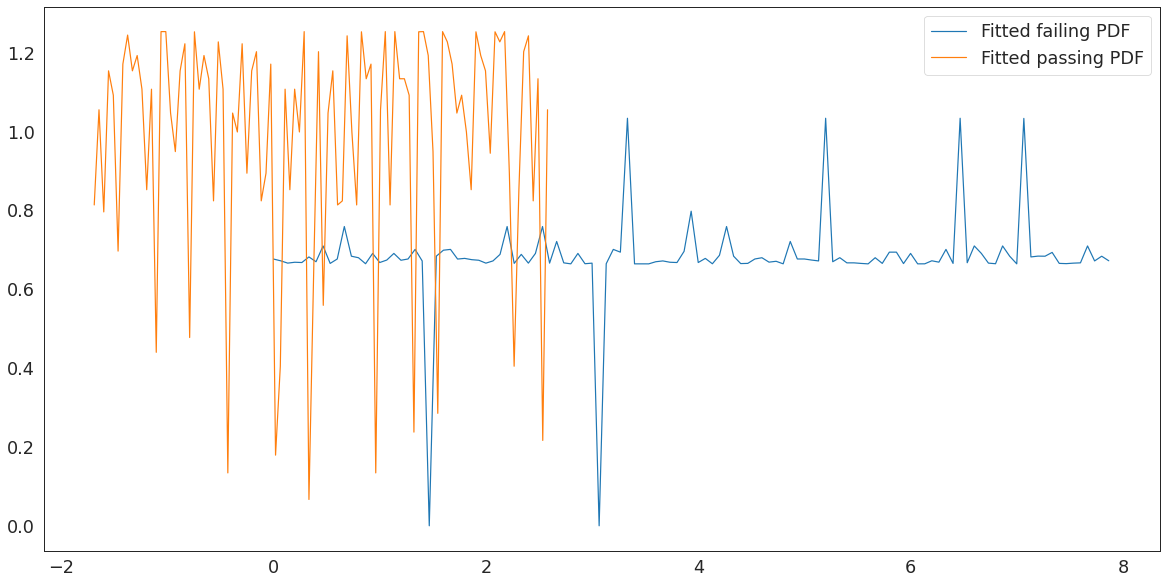

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(x_std_failing, y1, label='Fitted failing PDF')
plt.plot(x_std_passing, y2, label='Fitted passing PDF')
plt.legend()
plt.show()

In [34]:
# Obtain the intersection points between the distribution curves
x, y = intersection(x_std_failing,y1,x_std_passing,y2)

In [35]:
osp = max(x)
osp

2.5622280503925836

In [36]:
# Since we log transformed, reversing it to get the correct value
osp_original = np.exp(osp)
osp_original

12.964671100298238

## Validate on Test Data

Validate on the test data now to see how accurate the stopping point is.

In [37]:
passing_test = pd.read_csv('../data/processed/passing_test.csv')
failing_test = pd.read_csv('../data/processed/failing_test.csv')

In [38]:
passing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,24,2023-02-16T16:17:42Z,2023-02-16T16:18:14Z,4195960259,completed,success,32.0,28698040
1,2,2022-12-08T22:17:13Z,2022-12-08T22:17:36Z,3652574168,completed,success,23.0,28698040
2,10,2022-08-26T22:01:36Z,2022-08-26T22:02:36Z,2936826398,completed,success,60.0,28698040
3,11,2022-12-14T15:53:31Z,2022-12-14T15:54:12Z,3696463705,completed,success,41.0,28698040
4,10,2022-12-14T21:31:32Z,2022-12-14T21:32:11Z,3698893104,completed,success,39.0,28698040


In [39]:
failing_test.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,21,2022-09-16T11:44:55Z,2022-09-16T11:45:53Z,3067592900,completed,failure,58.0,28698040
1,28,2022-12-01T21:48:46Z,2022-12-01T21:49:24Z,3596813212,completed,failure,38.0,28698040
2,3,2022-10-11T21:26:36Z,2022-10-11T21:27:41Z,3230352147,completed,failure,65.0,28698040
3,23,2022-10-10T15:26:12Z,2022-10-10T15:27:12Z,3220492742,completed,failure,60.0,28698040
4,16,2022-09-28T18:22:02Z,2022-09-28T18:22:50Z,3145923511,completed,failure,48.0,28698040


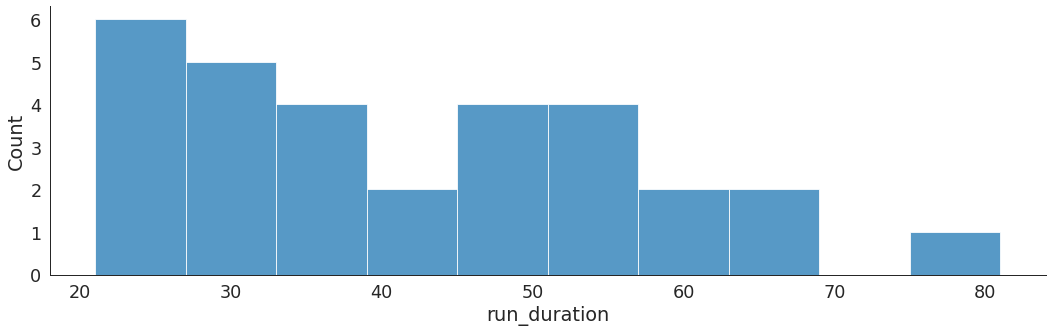

In [40]:
# Distribution of values of run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=failing_test, x="run_duration", kind="hist", bins = 10, aspect = 3)

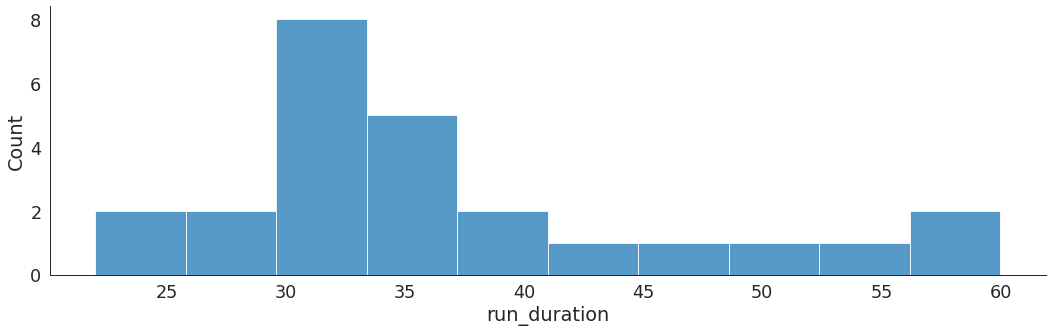

In [41]:
# Distribution of values of run duration
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=passing_test, x="run_duration", kind="hist", bins = 10, aspect = 3)

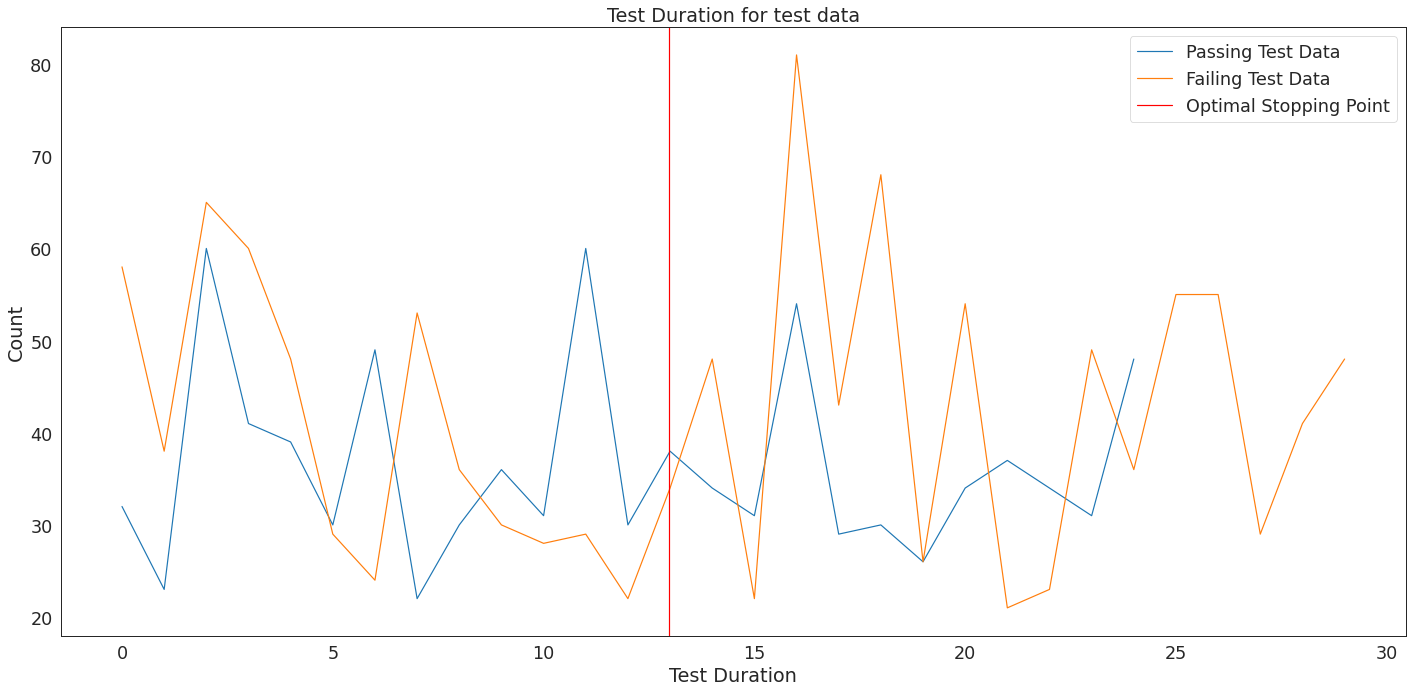

In [42]:
fig, ax = plt.subplots(figsize =(20,10))
ax.plot(passing_test.run_duration.values, label="Passing Test Data")
ax.plot(failing_test.run_duration.values, label="Failing Test Data")
ax.set_xlabel("Test Duration")
ax.set_ylabel("Count")
ax.set_title("Test Duration for test data")
ax.axvline(x=osp_original, color="r", label="Optimal Stopping Point")
fig.tight_layout()
plt.legend()
plt.show()

In [43]:
test_data = pd.concat([passing_test, failing_test], axis=0)

In [44]:
test_data.run_duration.values.sort()

In [45]:
test_data.head()

,Unnamed: 0,created_at,updated_at,run_id,status,conclusion,run_duration,test_id
0,24,2023-02-16T16:17:42Z,2023-02-16T16:18:14Z,4195960259,completed,success,21.0,28698040
1,2,2022-12-08T22:17:13Z,2022-12-08T22:17:36Z,3652574168,completed,success,22.0,28698040
2,10,2022-08-26T22:01:36Z,2022-08-26T22:02:36Z,2936826398,completed,success,22.0,28698040
3,11,2022-12-14T15:53:31Z,2022-12-14T15:54:12Z,3696463705,completed,success,22.0,28698040
4,10,2022-12-14T21:31:32Z,2022-12-14T21:32:11Z,3698893104,completed,success,23.0,28698040


In [46]:
test_data['predicted_status'] = np.where(test_data['run_duration'] > osp_original, 'failure', 'success')

In [47]:
# Calculate percentage of rows where "new_column" matches "conclusion"
accuracy = (test_data['predicted_status'] == test_data['conclusion']).sum() / len(test_data) * 100
print(f"Match percentage: {accuracy:.2f}%")

Match percentage: 54.55%


### Conclusion and Future work:

As we can see the match percentage is super low, we can try this on a different test to see if this approach works well or not.